In [1]:
import os
import sys

sys.path.append(os.path.join('/home/hassaku/ambiguous-segmentation/scripts/'))

import torch
import matplotlib.pyplot as plt

from modules.model import SegNet
from utils.data import get_dataloader

In [2]:
model = SegNet()

In [3]:
checkpoint = torch.load('/home/hassaku/ambiguous-segmentation/archives/2019-10-06_23:27/trimap_0030.model')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [4]:
test_dir = '../data/person_image_dataset/96x64/test/'
bg_dir = '../data/MSCOCO/test2017_mini/'
dataloader = get_dataloader(test_dir, bg_dir, batch_size=10, data_num=10)

100%|██████████| 10/10 [00:00<00:00, 756.17it/s]
10it [00:00, 5332.87it/s]

Portrait loaded.
BG loaded.
Finish piling.


In [5]:
for pile, fg, bg, alpha in dataloader:
    y = model(pile)

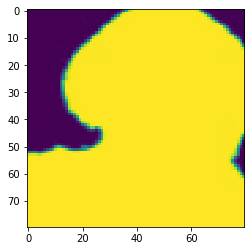

In [6]:
sample = (alpha.detach().numpy()[0].reshape([80, 80]) * 255).astype('uint8')
plt.imshow(sample)

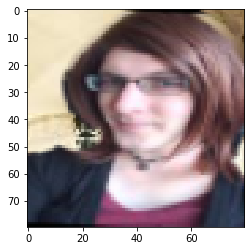

In [9]:
sample = (pile.detach().numpy()[0].transpose(1, 2, 0))
plt.imshow(sample)